In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib
import statsmodels
import tensorflow as tf

C:\Users\hirot\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(pd.__version__)
print(matplotlib.__version__)
print(statsmodels.__version__)
print(tf.__version__)

1.3.4
3.4.3
0.12.2
2.12.0


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.random.set_seed(5210)

In [5]:
accident2019 = pd.read_csv("Data/honhyo_2019.csv", encoding="Shift-JIS")
accident_additional_2019 = pd.read_csv("Data/hojuhyo_2019.csv", encoding="Shift-JIS")
accident_motorway_2019 = pd.read_csv("Data/kosokuhyo_2019.csv", encoding="Shift-JIS")

In [6]:
accident2020 = pd.read_csv("Data/honhyo_2020.csv", encoding="Shift-JIS")
accident_additional_2020 = pd.read_csv("Data/hojuhyo_2020.csv", encoding="Shift-JIS")
accident_motorway_2020 = pd.read_csv("Data/kosokuhyo_2020.csv", encoding="Shift-JIS")

In [7]:
accident2021 = pd.read_csv("Data/honhyo_2021.csv", encoding="Shift-JIS")
accident_additional_2021 = pd.read_csv("Data/hojuhyo_2021.csv", encoding="Shift-JIS")
accident_motorway_2021 = pd.read_csv("Data/kosokuhyo_2021.csv", encoding="Shift-JIS")

In [8]:
accident_all = pd.concat([accident2019,accident2020,accident2021])
accident_all.shape

(995611, 58)

In [9]:
accident2019["date"] = pd.to_datetime({"year":accident2019["発生日時　　年"],"month":accident2019["発生日時　　月"],
                                       "day":accident2019["発生日時　　日"]})
accident_all["date"] = pd.to_datetime({"year":accident_all["発生日時　　年"],"month":accident_all["発生日時　　月"],
                                       "day":accident_all["発生日時　　日"]})

In [10]:
accident2019.head()

,資料区分,都道府県コード,警察署等コード,本票番号,事故内容,死者数,負傷者数,路線コード,上下線,地点コード,...,エアバッグの装備（当事者B）,サイドエアバッグの装備（当事者A）,サイドエアバッグの装備（当事者B）,人身損傷程度（当事者A）,人身損傷程度（当事者B）,地点 緯度（北緯）,地点 経度（東経）,曜日(発生年月日),祝日(発生年月日),date
0,1,10,59,1,2,0,1,40030,2,0,...,2,2,2,4,4,431412959,1414947029,6,3,2018-12-28
1,1,10,59,2,2,0,2,40020,2,0,...,2,2,2,4,4,425706029,1413039991,1,3,2019-01-06
2,1,10,59,3,2,0,1,50020,1,0,...,2,2,2,4,4,424115557,1414158530,3,3,2018-12-18
3,1,10,59,4,2,0,1,40020,2,0,...,1,2,2,4,2,425647051,1413100440,7,3,2019-01-05
4,1,10,59,5,2,0,1,40140,2,0,...,2,2,2,4,2,425606992,1420518034,2,2,2018-12-31


In [11]:
accident2019.shape

(381237, 59)

In [12]:
ts = accident_all[["date","資料区分"]].groupby("date").count()
ts.columns=["accident_num"]
ts_holiday = accident_all[["date","曜日(発生年月日)"]].groupby("date").mean()
ts["DayOfWeek"]=ts_holiday["曜日(発生年月日)"]

In [13]:
ts["DayOfWeek"]=ts["DayOfWeek"].apply(str)

In [14]:
ts = pd.get_dummies(ts) # one-hot encoding

In [15]:
ts

,accident_num,DayOfWeek_1.0,DayOfWeek_2.0,DayOfWeek_3.0,DayOfWeek_4.0,DayOfWeek_5.0,DayOfWeek_6.0,DayOfWeek_7.0
date,,,,,,,,
2015-12-12,1,0,0,0,0,0,0,1
2016-01-18,1,0,1,0,0,0,0,0
2016-02-12,1,0,0,0,0,0,1,0
2016-03-09,1,0,0,0,1,0,0,0
2016-04-29,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
2021-12-27,697,0,1,0,0,0,0,0
2021-12-28,625,0,0,1,0,0,0,0
2021-12-29,396,0,0,0,1,0,0,0


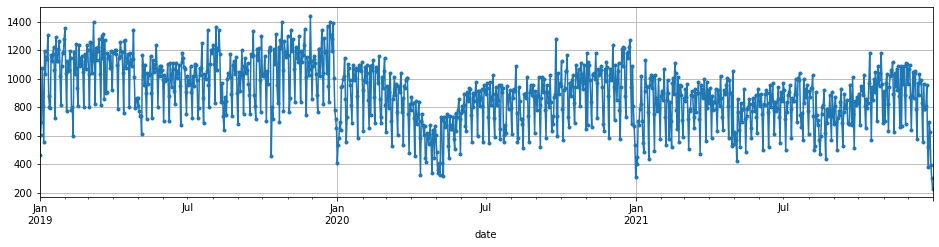

In [16]:
ts["accident_num"]["2019-01":"2022-12"].plot(grid=True, marker=".", figsize=(16, 3.5))
plt.show()

In [17]:
# normalise the data with minmax
ts["accident_num"] = (ts["accident_num"]-1) / (1442-1)

accident_train = ts["2019-01":"2020-12"]
accident_valid = ts["2021-01":"2021-11"]
accident_test = ts["2021-12":]

In [18]:
seq_length=56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_train.to_numpy(), # use all columns as input
targets=accident_train["accident_num"][seq_length:], 
sequence_length=seq_length,
batch_size=32,
shuffle=True,
seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_valid.to_numpy(),
targets=accident_valid["accident_num"][seq_length:],
sequence_length=seq_length,
batch_size=32
)

In [19]:
lstm_model = tf.keras.Sequential([
tf.keras.layers.LSTM(32, input_shape=[None, 8]),
tf.keras.layers.Dense(1)
])

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
22/22 [==============================] - 2s 25ms/step - loss: 0.0625 - mae: 0.2868 - val_loss: 0.0145 - val_mae: 0.1501
Epoch 2/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0144 - mae: 0.1344 - val_loss: 0.0056 - val_mae: 0.0829
Epoch 3/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0096 - mae: 0.1125 - val_loss: 0.0064 - val_mae: 0.0862
Epoch 4/500
22/22 [==============================] - 0s 12ms/step - loss: 0.0084 - mae: 0.1057 - val_loss: 0.0052 - val_mae: 0.0788
Epoch 5/500
22/22 [==============================] - 0s 12ms/step - loss: 0.0079 - mae: 0.1023 - val_loss: 0.0061 - val_mae: 0.0853
Epoch 6/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0072 - mae: 0.0972 - val_loss: 0.0049 - val_mae: 0.0768
Epoch 7/500
22/22 [==============================] - 0s 12ms/step - loss: 0.0067 - mae: 0.0941 - val_loss: 0.0047 - val_mae: 0.0758
Epoch 8/500
22/22 [==============================] - 0s 12ms/step - loss: 0.

22/22 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0562 - val_loss: 0.0020 - val_mae: 0.0448
Epoch 63/500
22/22 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0563 - val_loss: 0.0020 - val_mae: 0.0442
Epoch 64/500
22/22 [==============================] - 0s 20ms/step - loss: 0.0033 - mae: 0.0581 - val_loss: 0.0023 - val_mae: 0.0483
Epoch 65/500
22/22 [==============================] - 0s 19ms/step - loss: 0.0032 - mae: 0.0560 - val_loss: 0.0018 - val_mae: 0.0435
Epoch 66/500
22/22 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0568 - val_loss: 0.0019 - val_mae: 0.0437
Epoch 67/500
22/22 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0542 - val_loss: 0.0019 - val_mae: 0.0436
Epoch 68/500
22/22 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0541 - val_loss: 0.0019 - val_mae: 0.0436
Epoch 69/500
22/22 [==============================] - 0s 15ms/step - loss: 0.0031 

22/22 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0548 - val_loss: 0.0022 - val_mae: 0.0504
Epoch 124/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0032 - mae: 0.0566 - val_loss: 0.0018 - val_mae: 0.0439
Epoch 125/500
22/22 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0541 - val_loss: 0.0018 - val_mae: 0.0438
Epoch 126/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0030 - mae: 0.0537 - val_loss: 0.0018 - val_mae: 0.0435
Epoch 127/500
22/22 [==============================] - 0s 13ms/step - loss: 0.0030 - mae: 0.0538 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 128/500
22/22 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0550 - val_loss: 0.0018 - val_mae: 0.0437
Epoch 129/500
22/22 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0537 - val_loss: 0.0019 - val_mae: 0.0461
Epoch 130/500
22/22 [==============================] - 0s 13ms/step - loss: 

In [21]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid)]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = lstm_model.predict(X)
    print(y_pred_one)
    print(step_ahead)
    print(len(X[0]))
    print(X)
    # Create WeekDay
    if (step_ahead + 3) % 7 == 0:
        Sun = 1
    else:
        Sun = 0
    if (step_ahead + 2) % 7 == 0:
        Mon = 1
    else:
        Mon = 0
    if (step_ahead + 1) % 7 == 0:
        Tue = 1
    else:
        Tue = 0
    if (step_ahead + 0) % 7 == 0:
        Wed = 1
    else:
        Wed = 0
    if (step_ahead + 6) % 7 == 0:
        Thu = 1
    else:
        Thu = 0
    if (step_ahead + 5) % 7 == 0:
        Fri = 1
    else:
        Fri = 0
    if (step_ahead + 4) % 7 == 0:
        Sat = 1
    else:
        Sat = 0
    print([Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    y_pred_one=np.append(y_pred_one,[Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 8)], axis=1)

56
1/1 [==============================] - 0s 255ms/step
[[0.70696014]]
0
56
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.     

1/1 [==============================] - 0s 16ms/step
[[0.7824631]]
2
58
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         0

1/1 [==============================] - 0s 16ms/step
[[0.49846384]]
4
60
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 21ms/step
[[0.71099293]]
6
62
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 34ms/step
[[0.71053356]]
8
64
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 26ms/step
[[0.6272416]]
10
66
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 11ms/step
[[0.7067142]]
12
68
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 16ms/step
[[0.7006398]]
14
70
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 15ms/step
[[0.77723014]]
16
72
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.        

1/1 [==============================] - 0s 17ms/step
[[0.4935361]]
18
74
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 16ms/step
[[0.7065067]]
20
76
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 24ms/step
[[0.7063728]]
22
78
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 16ms/step
[[0.62333786]]
24
80
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.        

1/1 [==============================] - 0s 28ms/step
[[0.7028342]]
26
82
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 26ms/step
[[0.6969633]]
28
84
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

1/1 [==============================] - 0s 16ms/step
[[0.7738028]]
30
86
[[[0.63636364 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.61346287 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.7092297  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.56002776 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.4517696  1.         0.         0.         0.         0.
   0.         0.        ]
  [0.59195003 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.54961832 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.57529493 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.67244969 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.81818182 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.59888966 0.         0.         0.         0.         

In [22]:
X

array([[[0.63636364, 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        ],
        [0.61346287, 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        ],
        [0.7092297 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        ],
        [0.56002776, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        ],
        [0.4517696 , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.59195003, 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.54961832, 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.57529493, 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        ],
        [0.67244969, 0.        , 0.        , 0.        , 0.        ,
         1.

In [23]:
X_array = X.flatten()
X_array = X_array[X_array!=0]
X_array = X_array[X_array!=1]
X_array

array([0.63636364, 0.61346287, 0.7092297 , 0.56002776, 0.4517696 ,
       0.59195003, 0.54961832, 0.57529493, 0.67244969, 0.81818182,
       0.59888966, 0.39347675, 0.65163081, 0.59125607, 0.69049271,
       0.63011797, 0.7258848 , 0.67175573, 0.48646773, 0.75294934,
       0.69326856, 0.65510062, 0.71894518, 0.81956974, 0.66897988,
       0.47536433, 0.6315059 , 0.61068702, 0.48577377, 0.67244969,
       0.71755725, 0.56696738, 0.43580847, 0.65301874, 0.70645385,
       0.73490632, 0.7092297 , 0.77376822, 0.61623872, 0.43233865,
       0.72241499, 0.65579459, 0.73907009, 0.63983345, 0.75433727,
       0.6092991 , 0.45662734, 0.75294934, 0.46009715, 0.74531575,
       0.6648161 , 0.75641915, 0.61138099, 0.47397641, 0.76960444,
       0.76197085, 0.70696014, 0.71348137, 0.78246307, 0.63012314,
       0.49846384, 0.7094714 , 0.71099293, 0.7031948 , 0.71053356,
       0.77951467, 0.62724161, 0.49564767, 0.70671421, 0.70847452,
       0.70063978, 0.7082032 , 0.77723014, 0.62509727, 0.49353

In [24]:
xaxis = pd.date_range(start='12/1/2021', end='12/31/2021')
print(xaxis)

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='D')


In [25]:
ts["accident_num"]=(ts["accident_num"])*1441+1

In [26]:
X_array*1441

array([ 917.        ,  884.        , 1022.        ,  807.        ,
        651.        ,  853.        ,  792.        ,  829.        ,
        969.        , 1179.        ,  863.        ,  567.        ,
        939.        ,  852.        ,  995.        ,  908.        ,
       1046.        ,  968.        ,  701.        , 1085.        ,
        999.        ,  944.        , 1036.        , 1181.        ,
        964.        ,  685.        ,  910.        ,  880.        ,
        700.        ,  969.        , 1034.        ,  817.        ,
        628.        ,  941.        , 1018.        , 1059.        ,
       1022.        , 1115.        ,  888.        ,  623.        ,
       1041.        ,  945.        , 1065.        ,  922.        ,
       1087.        ,  878.        ,  658.        , 1085.        ,
        663.        , 1074.        ,  958.        , 1090.        ,
        881.        ,  683.        , 1109.        , 1098.        ,
       1018.72956413, 1028.12664932, 1127.52928925,  908.00744

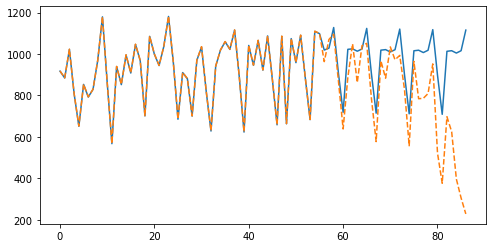

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-10-06":"2021-12"].tolist(), linestyle="dashed")
plt.show()

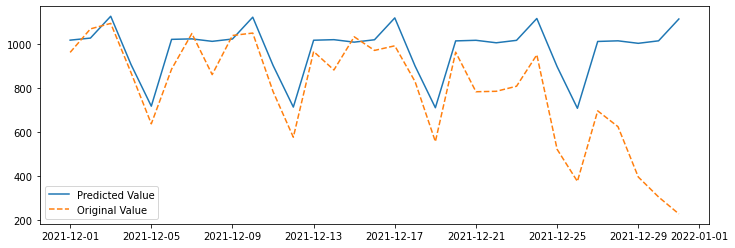

MAE: 194.15796861725468
MAPE: 43.21826354881012
RMSE: 284.3850805486788


In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

In [29]:
accident_train

,accident_num,DayOfWeek_1.0,DayOfWeek_2.0,DayOfWeek_3.0,DayOfWeek_4.0,DayOfWeek_5.0,DayOfWeek_6.0,DayOfWeek_7.0
date,,,,,,,,
2019-01-01,465.0,0,0,1,0,0,0,0
2019-01-02,606.0,0,0,0,1,0,0,0
2019-01-03,693.0,0,0,0,0,1,0,0
2019-01-04,1074.0,0,0,0,0,0,1,0
2019-01-05,806.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
2020-12-27,678.0,1,0,0,0,0,0,0
2020-12-28,1088.0,0,1,0,0,0,0,0
2020-12-29,810.0,0,0,1,0,0,0,0


In [30]:
# normalise the data with minmax
ts["accident_num"] = (ts["accident_num"]-1) / (1442-1)

accident_train = ts["2019-01":"2020-12"]
accident_valid = ts["2021-01":"2021-11"]
accident_test = ts["2021-12":]

In [31]:
seq_length=112
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_train.to_numpy(), # use all columns as input
targets=accident_train["accident_num"][seq_length:], 
sequence_length=seq_length,
batch_size=32,
shuffle=True,
seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_valid.to_numpy(),
targets=accident_valid["accident_num"][seq_length:],
sequence_length=seq_length,
batch_size=32
)

In [32]:
lstm_model = tf.keras.Sequential([
tf.keras.layers.LSTM(32, input_shape=[None, 8]),
tf.keras.layers.Dense(1)
])

In [33]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
20/20 [==============================] - 2s 35ms/step - loss: 0.0528 - mae: 0.2642 - val_loss: 0.0066 - val_mae: 0.0908
Epoch 2/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0148 - mae: 0.1390 - val_loss: 0.0111 - val_mae: 0.1259
Epoch 3/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0092 - mae: 0.1073 - val_loss: 0.0077 - val_mae: 0.1037
Epoch 4/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0087 - mae: 0.1060 - val_loss: 0.0050 - val_mae: 0.0823
Epoch 5/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0079 - mae: 0.1002 - val_loss: 0.0061 - val_mae: 0.0917
Epoch 6/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0074 - mae: 0.0963 - val_loss: 0.0051 - val_mae: 0.0841
Epoch 7/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0070 - mae: 0.0934 - val_loss: 0.0048 - val_mae: 0.0811
Epoch 8/500
20/20 [==============================] - 0s 20ms/step - loss: 0.

20/20 [==============================] - 0s 21ms/step - loss: 0.0032 - mae: 0.0558 - val_loss: 0.0021 - val_mae: 0.0481
Epoch 63/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0554 - val_loss: 0.0020 - val_mae: 0.0459
Epoch 64/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0559 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 65/500
20/20 [==============================] - 0s 19ms/step - loss: 0.0032 - mae: 0.0559 - val_loss: 0.0022 - val_mae: 0.0503
Epoch 66/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0032 - mae: 0.0559 - val_loss: 0.0020 - val_mae: 0.0457
Epoch 67/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0552 - val_loss: 0.0020 - val_mae: 0.0444
Epoch 68/500
20/20 [==============================] - 0s 19ms/step - loss: 0.0032 - mae: 0.0558 - val_loss: 0.0020 - val_mae: 0.0450
Epoch 69/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0031 

20/20 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0543 - val_loss: 0.0020 - val_mae: 0.0451
Epoch 124/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0031 - mae: 0.0551 - val_loss: 0.0020 - val_mae: 0.0448
Epoch 125/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0545 - val_loss: 0.0020 - val_mae: 0.0456


In [34]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid)]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = lstm_model.predict(X)
    print(y_pred_one)
    print(step_ahead)
    print(len(X[0]))
    print(X)
    # Create WeekDay
    if (step_ahead + 3) % 7 == 0:
        Sun = 1
    else:
        Sun = 0
    if (step_ahead + 2) % 7 == 0:
        Mon = 1
    else:
        Mon = 0
    if (step_ahead + 1) % 7 == 0:
        Tue = 1
    else:
        Tue = 0
    if (step_ahead + 0) % 7 == 0:
        Wed = 1
    else:
        Wed = 0
    if (step_ahead + 6) % 7 == 0:
        Thu = 1
    else:
        Thu = 0
    if (step_ahead + 5) % 7 == 0:
        Fri = 1
    else:
        Fri = 0
    if (step_ahead + 4) % 7 == 0:
        Sat = 1
    else:
        Sat = 0
    print([Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    y_pred_one=np.append(y_pred_one,[Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 8)], axis=1)

112
1/1 [==============================] - 0s 244ms/step
[[0.7065318]]
0
112
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.    

1/1 [==============================] - 0s 238ms/step
[[0.7181751]]
1
113
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.        

1/1 [==============================] - 0s 16ms/step
[[0.7840008]]
2
114
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.         

1/1 [==============================] - 0s 8ms/step
[[0.6346189]]
3
115
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.         0

1/1 [==============================] - 0s 16ms/step
[[0.49976432]]
4
116
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.        

1/1 [==============================] - 0s 23ms/step
[[0.7075538]]
5
117
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.         

[0, 1, 0, 0, 0, 0, 0]
[0.7075538 0.        1.        0.        0.        0.        0.
 0.       ]
1/1 [==============================] - 0s 16ms/step
[[0.71686214]]
6
118
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.        

1/1 [==============================] - 0s 16ms/step
[[0.70557386]]
7
119
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.        

1/1 [==============================] - 0s 30ms/step
[[0.7177547]]
8
120
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.         

1/1 [==============================] - 0s 31ms/step
[[0.7834584]]
9
121
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.         

1/1 [==============================] - 0s 29ms/step
[[0.6340222]]
10
122
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.        

1/1 [==============================] - 0s 16ms/step
[[0.49914902]]
11
123
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.       

1/1 [==============================] - 0s 31ms/step
[[0.70690286]]
12
124
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.       

1/1 [==============================] - 0s 17ms/step
[[0.71625423]]
13
125
[[[0.51492019 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.46773074 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.49132547 0.         0.         0.         0.         0.
   1.         0.        ]
  [0.39278279 0.         0.         0.         0.         0.
   0.         1.        ]
  [0.32685635 1.         0.         0.         0.         0.
   0.         0.        ]
  [0.41221374 0.         1.         0.         0.         0.
   0.         0.        ]
  [0.51977793 0.         0.         1.         0.         0.
   0.         0.        ]
  [0.55447606 0.         0.         0.         1.         0.
   0.         0.        ]
  [0.56419153 0.         0.         0.         0.         1.
   0.         0.        ]
  [0.6370576  0.         0.         0.         0.         0.
   1.         0.        ]
  [0.42678695 0.         0.         0.         0.       

1/1 [==============================] - 0s 35ms/step
[[0.70493144]]
14
126
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 1.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.49914902 1.         0.         ... 0.         0.         0.        ]
  [0.70690286 0.         1.         ... 0.         0.         0.        ]
  [0.71625423 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 1, 0, 0, 0]
[0.70493144 0.         0.         0.         1.         0.
 0.         0.        ]
1/1 [==============================] - 0s 16ms/step
[[0.7172009]]
15
127
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 1.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.70690286 0.         1.         ... 0.         0.         0.    

1/1 [==============================] - 0s 26ms/step
[[0.71548736]]
27
139
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 1.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.63315028 0.         0.         ... 0.         0.         1.        ]
  [0.49834079 1.         0.         ... 0.         0.         0.        ]
  [0.70609367 0.         1.         ... 0.         0.         0.        ]]]
[0, 0, 1, 0, 0, 0, 0]
[0.71548736 0.         0.         1.         0.         0.
 0.         0.        ]
1/1 [==============================] - 0s 33ms/step
[[0.7042044]]
28
140
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 1.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.49834079 1.         0.         ... 0.         0.         0.    

In [35]:
X_array = X.flatten()
X_array = X_array[X_array!=0]
X_array = X_array[X_array!=1]
X_array

array([0.51492019, 0.46773074, 0.49132547, 0.39278279, 0.32685635,
       0.41221374, 0.51977793, 0.55447606, 0.56419153, 0.6370576 ,
       0.42678695, 0.30256766, 0.54614851, 0.47814018, 0.53226926,
       0.51075642, 0.61276891, 0.50867453, 0.39486468, 0.6259542 ,
       0.54129077, 0.47258848, 0.56002776, 0.60235947, 0.47952811,
       0.34420541, 0.49895906, 0.53435115, 0.51561416, 0.5815406 ,
       0.64469119, 0.47605829, 0.3629424 , 0.53226926, 0.61693269,
       0.54892436, 0.5482304 , 0.58917418, 0.47814018, 0.47050659,
       0.47258848, 0.66273421, 0.60097155, 0.46703678, 0.69882026,
       0.52185982, 0.35461485, 0.58362248, 0.5648855 , 0.6037474 ,
       0.57529493, 0.6037474 , 0.6204025 , 0.46703678, 0.65648855,
       0.64399722, 0.63636364, 0.61346287, 0.7092297 , 0.56002776,
       0.4517696 , 0.59195003, 0.54961832, 0.57529493, 0.67244969,
       0.81818182, 0.59888966, 0.39347675, 0.65163081, 0.59125607,
       0.69049271, 0.63011797, 0.7258848 , 0.67175573, 0.48646

In [36]:
ts["accident_num"]=(ts["accident_num"])*1441+1

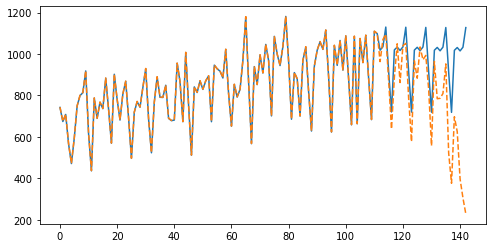

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-08-11":"2021-12"].tolist(), linestyle="dashed")
plt.show()

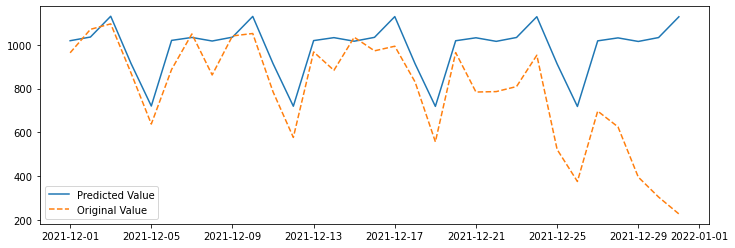

MAE: 200.10535884480322
MAPE: 44.34646699951105
RMSE: 291.51641289439203


In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

In [39]:
#Adding Month
ts = accident_all[["date","資料区分"]].groupby("date").count()
ts.columns=["accident_num"]
ts_holiday = accident_all[["date","曜日(発生年月日)","発生日時　　月","発生日時　　日"]].groupby("date").mean()
ts["DayOfWeek"]=ts_holiday["曜日(発生年月日)"]
ts["Month"]=ts_holiday["発生日時　　月"]

In [40]:
# Adding Month
ts["DayOfWeek"]=ts["DayOfWeek"].apply(str)
ts["Month"]=ts["Month"].apply(str)
ts = pd.get_dummies(ts) # one-hot encoding

In [41]:
# normalise the data with minmax
ts["accident_num"] = (ts["accident_num"]-1) / (1442-1)

accident_train = ts["2019-01":"2020-12"]
accident_valid = ts["2021-01":"2021-11"]
accident_test = ts["2021-12":]

In [42]:
seq_length=112
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_train.to_numpy(), # use all columns as input
targets=accident_train["accident_num"][seq_length:], 
sequence_length=seq_length,
batch_size=32,
shuffle=True,
seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_valid.to_numpy(),
targets=accident_valid["accident_num"][seq_length:],
sequence_length=seq_length,
batch_size=32
)

In [43]:
lstm_model = tf.keras.Sequential([
tf.keras.layers.LSTM(32, input_shape=[None, 20]),
tf.keras.layers.Dense(1)
])

In [44]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
20/20 [==============================] - 3s 57ms/step - loss: 0.0346 - mae: 0.2080 - val_loss: 0.0091 - val_mae: 0.1171
Epoch 2/500
20/20 [==============================] - 1s 33ms/step - loss: 0.0111 - mae: 0.1198 - val_loss: 0.0051 - val_mae: 0.0763
Epoch 3/500
20/20 [==============================] - 1s 31ms/step - loss: 0.0073 - mae: 0.0970 - val_loss: 0.0064 - val_mae: 0.0879
Epoch 4/500
20/20 [==============================] - 1s 31ms/step - loss: 0.0063 - mae: 0.0895 - val_loss: 0.0040 - val_mae: 0.0694
Epoch 5/500
20/20 [==============================] - 1s 31ms/step - loss: 0.0059 - mae: 0.0851 - val_loss: 0.0043 - val_mae: 0.0721
Epoch 6/500
20/20 [==============================] - 1s 31ms/step - loss: 0.0055 - mae: 0.0819 - val_loss: 0.0039 - val_mae: 0.0683
Epoch 7/500
20/20 [==============================] - 1s 33ms/step - loss: 0.0053 - mae: 0.0800 - val_loss: 0.0035 - val_mae: 0.0650
Epoch 8/500
20/20 [==============================] - 1s 32ms/step - loss: 0.

20/20 [==============================] - 0s 22ms/step - loss: 0.0031 - mae: 0.0560 - val_loss: 0.0021 - val_mae: 0.0484
Epoch 63/500
20/20 [==============================] - 0s 25ms/step - loss: 0.0031 - mae: 0.0565 - val_loss: 0.0021 - val_mae: 0.0476
Epoch 64/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0031 - mae: 0.0566 - val_loss: 0.0021 - val_mae: 0.0482
Epoch 65/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0031 - mae: 0.0567 - val_loss: 0.0021 - val_mae: 0.0486
Epoch 66/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0031 - mae: 0.0562 - val_loss: 0.0021 - val_mae: 0.0468
Epoch 67/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0030 - mae: 0.0557 - val_loss: 0.0022 - val_mae: 0.0477
Epoch 68/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0031 - mae: 0.0560 - val_loss: 0.0021 - val_mae: 0.0468
Epoch 69/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0031 

20/20 [==============================] - 1s 25ms/step - loss: 0.0029 - mae: 0.0540 - val_loss: 0.0021 - val_mae: 0.0464
Epoch 124/500
20/20 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0546 - val_loss: 0.0021 - val_mae: 0.0463
Epoch 125/500
20/20 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0542 - val_loss: 0.0021 - val_mae: 0.0472
Epoch 126/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0030 - mae: 0.0544 - val_loss: 0.0021 - val_mae: 0.0465
Epoch 127/500
20/20 [==============================] - 1s 55ms/step - loss: 0.0029 - mae: 0.0544 - val_loss: 0.0021 - val_mae: 0.0470
Epoch 128/500
20/20 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0548 - val_loss: 0.0021 - val_mae: 0.0471
Epoch 129/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0030 - mae: 0.0552 - val_loss: 0.0021 - val_mae: 0.0472
Epoch 130/500
20/20 [==============================] - 1s 37ms/step - loss: 

20/20 [==============================] - 1s 34ms/step - loss: 0.0028 - mae: 0.0531 - val_loss: 0.0021 - val_mae: 0.0463
Epoch 185/500
20/20 [==============================] - 1s 35ms/step - loss: 0.0028 - mae: 0.0529 - val_loss: 0.0021 - val_mae: 0.0460
Epoch 186/500
20/20 [==============================] - 1s 35ms/step - loss: 0.0028 - mae: 0.0529 - val_loss: 0.0021 - val_mae: 0.0460
Epoch 187/500
20/20 [==============================] - 1s 26ms/step - loss: 0.0028 - mae: 0.0533 - val_loss: 0.0021 - val_mae: 0.0459
Epoch 188/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0028 - mae: 0.0529 - val_loss: 0.0020 - val_mae: 0.0462
Epoch 189/500
20/20 [==============================] - 1s 27ms/step - loss: 0.0029 - mae: 0.0537 - val_loss: 0.0021 - val_mae: 0.0475
Epoch 190/500
20/20 [==============================] - 1s 35ms/step - loss: 0.0030 - mae: 0.0553 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 191/500
20/20 [==============================] - 1s 34ms/step - loss: 

20/20 [==============================] - 1s 27ms/step - loss: 0.0028 - mae: 0.0523 - val_loss: 0.0021 - val_mae: 0.0462
Epoch 246/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0028 - mae: 0.0539 - val_loss: 0.0021 - val_mae: 0.0460
Epoch 247/500
20/20 [==============================] - 1s 26ms/step - loss: 0.0027 - mae: 0.0523 - val_loss: 0.0020 - val_mae: 0.0460
Epoch 248/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0028 - mae: 0.0535 - val_loss: 0.0021 - val_mae: 0.0461
Epoch 249/500
20/20 [==============================] - 1s 27ms/step - loss: 0.0028 - mae: 0.0530 - val_loss: 0.0021 - val_mae: 0.0460
Epoch 250/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0027 - mae: 0.0524 - val_loss: 0.0022 - val_mae: 0.0474
Epoch 251/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0027 - mae: 0.0518 - val_loss: 0.0020 - val_mae: 0.0457
Epoch 252/500
20/20 [==============================] - 1s 27ms/step - loss: 

20/20 [==============================] - 1s 29ms/step - loss: 0.0027 - mae: 0.0521 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 307/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0028 - mae: 0.0534 - val_loss: 0.0021 - val_mae: 0.0458
Epoch 308/500
20/20 [==============================] - 1s 30ms/step - loss: 0.0027 - mae: 0.0521 - val_loss: 0.0020 - val_mae: 0.0456
Epoch 309/500
20/20 [==============================] - 1s 27ms/step - loss: 0.0027 - mae: 0.0519 - val_loss: 0.0021 - val_mae: 0.0459
Epoch 310/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0027 - mae: 0.0519 - val_loss: 0.0020 - val_mae: 0.0456
Epoch 311/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0027 - mae: 0.0523 - val_loss: 0.0020 - val_mae: 0.0463
Epoch 312/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0027 - mae: 0.0519 - val_loss: 0.0020 - val_mae: 0.0469
Epoch 313/500
20/20 [==============================] - 1s 24ms/step - loss: 

20/20 [==============================] - 1s 25ms/step - loss: 0.0026 - mae: 0.0510 - val_loss: 0.0021 - val_mae: 0.0463
Epoch 368/500
20/20 [==============================] - 0s 24ms/step - loss: 0.0026 - mae: 0.0511 - val_loss: 0.0020 - val_mae: 0.0458


In [45]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid)]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = lstm_model.predict(X)
    print(y_pred_one)
    print(step_ahead)
    print(len(X[0]))
    print(X)
    # Create WeekDay
    if (step_ahead + 3) % 7 == 0:
        Sun = 1
    else:
        Sun = 0
    if (step_ahead + 2) % 7 == 0:
        Mon = 1
    else:
        Mon = 0
    if (step_ahead + 1) % 7 == 0:
        Tue = 1
    else:
        Tue = 0
    if (step_ahead + 0) % 7 == 0:
        Wed = 1
    else:
        Wed = 0
    if (step_ahead + 6) % 7 == 0:
        Thu = 1
    else:
        Thu = 0
    if (step_ahead + 5) % 7 == 0:
        Fri = 1
    else:
        Fri = 0
    if (step_ahead + 4) % 7 == 0:
        Sat = 1
    else:
        Sat = 0
    print([Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    y_pred_one=np.append(y_pred_one,[Sun,Mon,Tue,Wed,Thu,Fri,Sat])# append Day of week
    y_pred_one=np.append(y_pred_one,[0,0,0,1,0,0,0,0,0,0,0,0])# append Month (predicting value is December) 
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 20)], axis=1)

112
1/1 [==============================] - 0s 258ms/step
[[0.7349625]]
0
112
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.47397641 1.         0.         ... 0.         0.         0.        ]
  [0.76960444 0.         1.         ... 0.         0.         0.        ]
  [0.76197085 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 1, 0, 0, 0]
[0.73496252 0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
1/1 [==============================] - 0s 262ms/step
[[0.73427296]]
1
113
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0

1/1 [==============================] - 0s 22ms/step
[[0.53684187]]
11
123
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.75228924 0.         0.         ... 0.         0.         0.        ]
  [0.81806344 0.         0.         ... 0.         0.         0.        ]
  [0.66453016 0.         0.         ... 0.         0.         0.        ]]]
[1, 0, 0, 0, 0, 0, 0]
[0.53684187 1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
1/1 [==============================] - 0s 34ms/step
[[0.74434847]]
12
124
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0.  

1/1 [==============================] - 0s 16ms/step
[[0.6309363]]
22
134
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0.         ... 0.         1.         0.        ]
  ...
  [0.68071312 0.         1.         ... 0.         0.         0.        ]
  [0.6703735  0.         0.         ... 0.         0.         0.        ]
  [0.63711822 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 1, 0, 0]
[0.63093632 0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
1/1 [==============================] - 0s 18ms/step
[[0.6788882]]
23
135
[[[0.51492019 0.         0.         ... 0.         1.         0.        ]
  [0.46773074 0.         0.         ... 0.         1.         0.        ]
  [0.49132547 0.         0.    

In [46]:
X_array = X.flatten()
X_array = X_array[X_array!=0]
X_array = X_array[X_array!=1]
X_array

array([0.51492019, 0.46773074, 0.49132547, 0.39278279, 0.32685635,
       0.41221374, 0.51977793, 0.55447606, 0.56419153, 0.6370576 ,
       0.42678695, 0.30256766, 0.54614851, 0.47814018, 0.53226926,
       0.51075642, 0.61276891, 0.50867453, 0.39486468, 0.6259542 ,
       0.54129077, 0.47258848, 0.56002776, 0.60235947, 0.47952811,
       0.34420541, 0.49895906, 0.53435115, 0.51561416, 0.5815406 ,
       0.64469119, 0.47605829, 0.3629424 , 0.53226926, 0.61693269,
       0.54892436, 0.5482304 , 0.58917418, 0.47814018, 0.47050659,
       0.47258848, 0.66273421, 0.60097155, 0.46703678, 0.69882026,
       0.52185982, 0.35461485, 0.58362248, 0.5648855 , 0.6037474 ,
       0.57529493, 0.6037474 , 0.6204025 , 0.46703678, 0.65648855,
       0.64399722, 0.63636364, 0.61346287, 0.7092297 , 0.56002776,
       0.4517696 , 0.59195003, 0.54961832, 0.57529493, 0.67244969,
       0.81818182, 0.59888966, 0.39347675, 0.65163081, 0.59125607,
       0.69049271, 0.63011797, 0.7258848 , 0.67175573, 0.48646

In [47]:
ts["accident_num"]=(ts["accident_num"])*1441+1

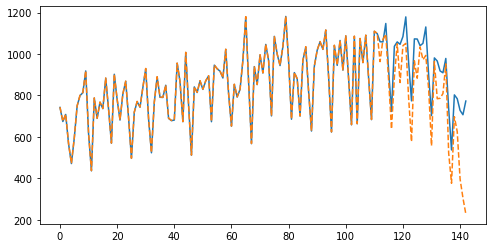

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-08-11":"2021-12"].tolist(), linestyle="dashed")
plt.show()

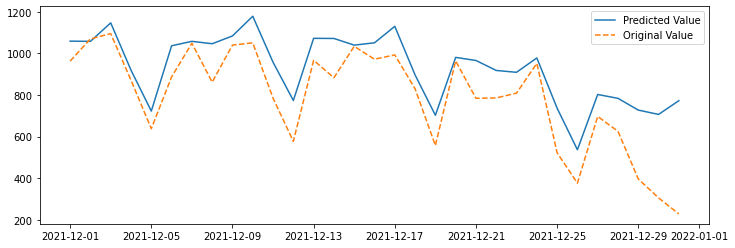

MAE: 138.10653149889362
MAPE: 28.093304273937587
RMSE: 179.62430199845008


In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

In [50]:
# Adding Day
ts = accident_all[["date","資料区分"]].groupby("date").count()
ts.columns=["accident_num"]
ts_holiday = accident_all[["date","曜日(発生年月日)","発生日時　　月","発生日時　　日"]].groupby("date").mean()
ts["DayOfWeek"]=ts_holiday["曜日(発生年月日)"]
ts["Month"]=ts_holiday["発生日時　　月"]
ts["Day"]=ts_holiday["発生日時　　日"]

In [51]:
ts

,accident_num,DayOfWeek,Month,Day
date,,,,
2015-12-12,1,7.0,12.0,12.0
2016-01-18,1,2.0,1.0,18.0
2016-02-12,1,6.0,2.0,12.0
2016-03-09,1,4.0,3.0,9.0
2016-04-29,1,6.0,4.0,29.0
...,...,...,...,...
2021-12-27,697,2.0,12.0,27.0
2021-12-28,625,3.0,12.0,28.0
2021-12-29,396,4.0,12.0,29.0


In [52]:
# Adding Day decreases the accuracy
ts["DayOfWeek"]=ts["DayOfWeek"].apply(str)
ts["Month"]=ts["Month"].apply(str)
ts["Day"]=ts["Day"].apply(str)
ts = pd.get_dummies(ts) # one-hot encoding

In [53]:
ts.columns

Index(['accident_num', 'DayOfWeek_1.0', 'DayOfWeek_2.0', 'DayOfWeek_3.0',
       'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0', 'DayOfWeek_7.0',
       'Month_1.0', 'Month_10.0', 'Month_11.0', 'Month_12.0', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Day_1.0', 'Day_10.0', 'Day_11.0', 'Day_12.0',
       'Day_13.0', 'Day_14.0', 'Day_15.0', 'Day_16.0', 'Day_17.0', 'Day_18.0',
       'Day_19.0', 'Day_2.0', 'Day_20.0', 'Day_21.0', 'Day_22.0', 'Day_23.0',
       'Day_24.0', 'Day_25.0', 'Day_26.0', 'Day_27.0', 'Day_28.0', 'Day_29.0',
       'Day_3.0', 'Day_30.0', 'Day_31.0', 'Day_4.0', 'Day_5.0', 'Day_6.0',
       'Day_7.0', 'Day_8.0', 'Day_9.0'],
      dtype='object')

In [54]:
ts.reindex(columns=['accident_num', 'DayOfWeek_1.0', 'DayOfWeek_2.0', 'DayOfWeek_3.0',
       'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0', 'DayOfWeek_7.0',
       'Month_1.0', 'Month_10.0', 'Month_11.0', 'Month_12.0', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Day_1.0', 'Day_2.0', 'Day_3.0', 
       'Day_4.0', 'Day_5.0', 'Day_6.0',
       'Day_7.0', 'Day_8.0', 'Day_9.0','Day_10.0', 'Day_11.0', 'Day_12.0',
       'Day_13.0', 'Day_14.0', 'Day_15.0', 'Day_16.0', 'Day_17.0', 'Day_18.0',
       'Day_19.0', 'Day_20.0', 'Day_21.0', 'Day_22.0', 'Day_23.0',
       'Day_24.0', 'Day_25.0', 'Day_26.0', 'Day_27.0', 'Day_28.0', 'Day_29.0', 'Day_30.0', 'Day_31.0'])

,accident_num,DayOfWeek_1.0,DayOfWeek_2.0,DayOfWeek_3.0,DayOfWeek_4.0,DayOfWeek_5.0,DayOfWeek_6.0,DayOfWeek_7.0,Month_1.0,Month_10.0,...,Day_22.0,Day_23.0,Day_24.0,Day_25.0,Day_26.0,Day_27.0,Day_28.0,Day_29.0,Day_30.0,Day_31.0
date,,,,,,,,,,,,,,,,,,,,,
2015-12-12,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-18,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-12,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-09,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-29,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,697,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2021-12-28,625,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2021-12-29,396,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
# normalise the data with minmax
ts["accident_num"] = (ts["accident_num"]-1) / (1442-1)

accident_train = ts["2019-01":"2020-12"]
accident_valid = ts["2021-01":"2021-11"]
accident_test = ts["2021-12":]

In [56]:
seq_length=112
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_train.to_numpy(), # use all columns as input
targets=accident_train["accident_num"][seq_length:], 
sequence_length=seq_length,
batch_size=32,
shuffle=True,
seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_valid.to_numpy(),
targets=accident_valid["accident_num"][seq_length:],
sequence_length=seq_length,
batch_size=32
)

In [57]:
lstm_model = tf.keras.Sequential([
tf.keras.layers.LSTM(32, input_shape=[None, 51]),
tf.keras.layers.Dense(1)
])

In [58]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
20/20 [==============================] - 3s 55ms/step - loss: 0.0573 - mae: 0.2752 - val_loss: 0.0067 - val_mae: 0.0951
Epoch 2/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0126 - mae: 0.1295 - val_loss: 0.0119 - val_mae: 0.1235
Epoch 3/500
20/20 [==============================] - 1s 30ms/step - loss: 0.0087 - mae: 0.1061 - val_loss: 0.0062 - val_mae: 0.0866
Epoch 4/500
20/20 [==============================] - 1s 37ms/step - loss: 0.0077 - mae: 0.0986 - val_loss: 0.0048 - val_mae: 0.0772
Epoch 5/500
20/20 [==============================] - 1s 32ms/step - loss: 0.0071 - mae: 0.0939 - val_loss: 0.0066 - val_mae: 0.0898
Epoch 6/500
20/20 [==============================] - 1s 32ms/step - loss: 0.0068 - mae: 0.0917 - val_loss: 0.0051 - val_mae: 0.0785
Epoch 7/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0064 - mae: 0.0890 - val_loss: 0.0048 - val_mae: 0.0763
Epoch 8/500
20/20 [==============================] - 1s 27ms/step - loss: 0.

20/20 [==============================] - 0s 22ms/step - loss: 0.0030 - mae: 0.0551 - val_loss: 0.0021 - val_mae: 0.0486
Epoch 63/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0029 - mae: 0.0549 - val_loss: 0.0022 - val_mae: 0.0492
Epoch 64/500
20/20 [==============================] - 0s 24ms/step - loss: 0.0029 - mae: 0.0550 - val_loss: 0.0021 - val_mae: 0.0487
Epoch 65/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0553 - val_loss: 0.0022 - val_mae: 0.0491
Epoch 66/500
20/20 [==============================] - 0s 24ms/step - loss: 0.0029 - mae: 0.0550 - val_loss: 0.0023 - val_mae: 0.0508
Epoch 67/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0548 - val_loss: 0.0024 - val_mae: 0.0513
Epoch 68/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0030 - mae: 0.0552 - val_loss: 0.0021 - val_mae: 0.0486
Epoch 69/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0029 

20/20 [==============================] - 0s 21ms/step - loss: 0.0026 - mae: 0.0518 - val_loss: 0.0020 - val_mae: 0.0473
Epoch 124/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0027 - mae: 0.0524 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 125/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0027 - mae: 0.0520 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 126/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0027 - mae: 0.0520 - val_loss: 0.0021 - val_mae: 0.0484
Epoch 127/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0027 - mae: 0.0521 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 128/500
20/20 [==============================] - 0s 24ms/step - loss: 0.0026 - mae: 0.0519 - val_loss: 0.0021 - val_mae: 0.0477
Epoch 129/500
20/20 [==============================] - 1s 26ms/step - loss: 0.0027 - mae: 0.0522 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 130/500
20/20 [==============================] - 0s 24ms/step - loss: 

20/20 [==============================] - 0s 23ms/step - loss: 0.0025 - mae: 0.0506 - val_loss: 0.0021 - val_mae: 0.0486
Epoch 185/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0025 - mae: 0.0505 - val_loss: 0.0020 - val_mae: 0.0477
Epoch 186/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0025 - mae: 0.0505 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 187/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0025 - mae: 0.0506 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 188/500
20/20 [==============================] - 1s 27ms/step - loss: 0.0025 - mae: 0.0503 - val_loss: 0.0020 - val_mae: 0.0476
Epoch 189/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0025 - mae: 0.0505 - val_loss: 0.0020 - val_mae: 0.0471
Epoch 190/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0521 - val_loss: 0.0020 - val_mae: 0.0470
Epoch 191/500
20/20 [==============================] - 0s 23ms/step - loss: 

20/20 [==============================] - 0s 22ms/step - loss: 0.0024 - mae: 0.0499 - val_loss: 0.0021 - val_mae: 0.0481
Epoch 246/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0024 - mae: 0.0500 - val_loss: 0.0020 - val_mae: 0.0478
Epoch 247/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0024 - mae: 0.0495 - val_loss: 0.0020 - val_mae: 0.0473
Epoch 248/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0024 - mae: 0.0504 - val_loss: 0.0021 - val_mae: 0.0483


In [59]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid)]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = lstm_model.predict(X)
    print(y_pred_one)
    print(step_ahead)
    print(len(X[0]))
    print(X)
    # Create WeekDay
    if (step_ahead + 3) % 7 == 0:
        Sun = 1
    else:
        Sun = 0
    if (step_ahead + 2) % 7 == 0:
        Mon = 1
    else:
        Mon = 0
    if (step_ahead + 1) % 7 == 0:
        Tue = 1
    else:
        Tue = 0
    if (step_ahead + 0) % 7 == 0:
        Wed = 1
    else:
        Wed = 0
    if (step_ahead + 6) % 7 == 0:
        Thu = 1
    else:
        Thu = 0
    if (step_ahead + 5) % 7 == 0:
        Fri = 1
    else:
        Fri = 0
    if (step_ahead + 4) % 7 == 0:
        Sat = 1
    else:
        Sat = 0
    print([Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    y_pred_one=np.append(y_pred_one,[Sun,Mon,Tue,Wed,Thu,Fri,Sat])# append Day of week
    y_pred_one=np.append(y_pred_one,[0,0,0,1,0,0,0,0,0,0,0,0])# append Month (predicting value is December)
    day=31*[0]
    day[step_ahead]=1
    y_pred_one=np.append(y_pred_one,day)# append Day 
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 51)], axis=1)

112
1/1 [==============================] - 0s 233ms/step
[[0.7154714]]
0
112
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.47397641 1.         0.         ... 0.         0.         0.        ]
  [0.76960444 0.         1.         ... 0.         0.         0.        ]
  [0.76197085 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 1, 0, 0, 0]
[0.71547139 0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

1/1 [==============================] - 0s 21ms/step
[[0.69901764]]
8
120
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.68855947 0.         1.         ... 0.         0.         0.        ]
  [0.69265813 0.         0.         ... 0.         0.         0.        ]
  [0.66984093 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 1, 0, 0]
[0.69901764 0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

1/1 [==============================] - 0s 19ms/step
[[0.689762]]
16
128
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.64404565 0.         0.         ... 0.         0.         0.        ]
  [0.60458231 0.         0.         ... 0.         0.         0.        ]
  [0.60107261 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 0, 1, 0]
[0.689762 0.       0.       0.       0.       0.       1.       0.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       1.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.      ]
1/1 [==================

1/1 [==============================] - 0s 19ms/step
[[0.39372367]]
24
136
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.49860352 0.         0.         ... 0.         0.         0.        ]
  [0.50038862 0.         0.         ... 0.         0.         0.        ]
  [0.57505667 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 0, 0, 1]
[0.39372367 0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.   

In [60]:
X_array = X.flatten()
X_array = X_array[X_array!=0]
X_array = X_array[X_array!=1]
X_array

array([0.51492019, 0.46773074, 0.49132547, 0.39278279, 0.32685635,
       0.41221374, 0.51977793, 0.55447606, 0.56419153, 0.6370576 ,
       0.42678695, 0.30256766, 0.54614851, 0.47814018, 0.53226926,
       0.51075642, 0.61276891, 0.50867453, 0.39486468, 0.6259542 ,
       0.54129077, 0.47258848, 0.56002776, 0.60235947, 0.47952811,
       0.34420541, 0.49895906, 0.53435115, 0.51561416, 0.5815406 ,
       0.64469119, 0.47605829, 0.3629424 , 0.53226926, 0.61693269,
       0.54892436, 0.5482304 , 0.58917418, 0.47814018, 0.47050659,
       0.47258848, 0.66273421, 0.60097155, 0.46703678, 0.69882026,
       0.52185982, 0.35461485, 0.58362248, 0.5648855 , 0.6037474 ,
       0.57529493, 0.6037474 , 0.6204025 , 0.46703678, 0.65648855,
       0.64399722, 0.63636364, 0.61346287, 0.7092297 , 0.56002776,
       0.4517696 , 0.59195003, 0.54961832, 0.57529493, 0.67244969,
       0.81818182, 0.59888966, 0.39347675, 0.65163081, 0.59125607,
       0.69049271, 0.63011797, 0.7258848 , 0.67175573, 0.48646

In [61]:
ts["accident_num"]=(ts["accident_num"])*1441+1

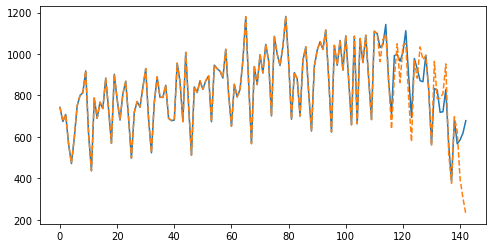

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-08-11":"2021-12"].tolist(), linestyle="dashed")
plt.show()

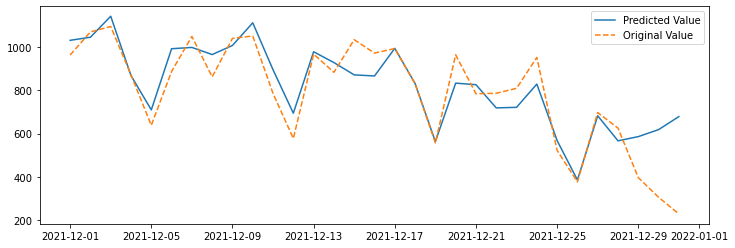

MAE: 85.78599176772178
MAPE: 17.843607691206135
RMSE: 126.49394167988913


In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

In [64]:
#Adding Month, Day and EndOfYear
ts = accident_all[["date","資料区分"]].groupby("date").count()
ts.columns=["accident_num"]
ts_holiday = accident_all[["date","曜日(発生年月日)","発生日時　　月","発生日時　　日"]].groupby("date").mean()
ts["DayOfWeek"]=ts_holiday["曜日(発生年月日)"]
ts["Month"]=ts_holiday["発生日時　　月"]
ts["Day"]=ts_holiday["発生日時　　日"]
ts["EndOfYear"]=0

In [65]:
ts["EndOfYear"]["2019-12-20":"2019-12-31"]=1
ts["EndOfYear"]["2020-12-20":"2020-12-31"]=1
ts["EndOfYear"]["2021-12-20":"2021-12-31"]=1

In [66]:
# Adding Month
ts["DayOfWeek"]=ts["DayOfWeek"].apply(str)
ts["Month"]=ts["Month"].apply(str)
ts["Day"]=ts["Day"].apply(str)
ts = pd.get_dummies(ts) # one-hot encoding

In [67]:
ts.columns

Index(['accident_num', 'EndOfYear', 'DayOfWeek_1.0', 'DayOfWeek_2.0',
       'DayOfWeek_3.0', 'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0',
       'DayOfWeek_7.0', 'Month_1.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
       'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0',
       'Month_7.0', 'Month_8.0', 'Month_9.0', 'Day_1.0', 'Day_10.0',
       'Day_11.0', 'Day_12.0', 'Day_13.0', 'Day_14.0', 'Day_15.0', 'Day_16.0',
       'Day_17.0', 'Day_18.0', 'Day_19.0', 'Day_2.0', 'Day_20.0', 'Day_21.0',
       'Day_22.0', 'Day_23.0', 'Day_24.0', 'Day_25.0', 'Day_26.0', 'Day_27.0',
       'Day_28.0', 'Day_29.0', 'Day_3.0', 'Day_30.0', 'Day_31.0', 'Day_4.0',
       'Day_5.0', 'Day_6.0', 'Day_7.0', 'Day_8.0', 'Day_9.0'],
      dtype='object')

In [68]:
ts.reindex(columns=['accident_num', 'EndOfYear', 'DayOfWeek_1.0', 'DayOfWeek_2.0', 'DayOfWeek_3.0',
       'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0', 'DayOfWeek_7.0',
       'Month_1.0', 'Month_10.0', 'Month_11.0', 'Month_12.0', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Day_1.0', 'Day_2.0', 'Day_3.0', 
       'Day_4.0', 'Day_5.0', 'Day_6.0',
       'Day_7.0', 'Day_8.0', 'Day_9.0','Day_10.0', 'Day_11.0', 'Day_12.0',
       'Day_13.0', 'Day_14.0', 'Day_15.0', 'Day_16.0', 'Day_17.0', 'Day_18.0',
       'Day_19.0', 'Day_20.0', 'Day_21.0', 'Day_22.0', 'Day_23.0',
       'Day_24.0', 'Day_25.0', 'Day_26.0', 'Day_27.0', 'Day_28.0', 'Day_29.0', 'Day_30.0', 'Day_31.0'])

,accident_num,EndOfYear,DayOfWeek_1.0,DayOfWeek_2.0,DayOfWeek_3.0,DayOfWeek_4.0,DayOfWeek_5.0,DayOfWeek_6.0,DayOfWeek_7.0,Month_1.0,...,Day_22.0,Day_23.0,Day_24.0,Day_25.0,Day_26.0,Day_27.0,Day_28.0,Day_29.0,Day_30.0,Day_31.0
date,,,,,,,,,,,,,,,,,,,,,
2015-12-12,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-18,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-02-12,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-09,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-29,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,697,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2021-12-28,625,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2021-12-29,396,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [69]:
# normalise the data with minmax
ts["accident_num"] = (ts["accident_num"]-1) / (1442-1)

accident_train = ts["2019-01":"2020-12"]
accident_valid = ts["2021-01":"2021-11"]
accident_test = ts["2021-12":]

In [70]:
seq_length=112
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_train.to_numpy(), # use all columns as input
targets=accident_train["accident_num"][seq_length:], 
sequence_length=seq_length,
batch_size=32,
shuffle=True,
seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
accident_valid.to_numpy(),
targets=accident_valid["accident_num"][seq_length:],
sequence_length=seq_length,
batch_size=32
)

In [71]:
lstm_model = tf.keras.Sequential([
tf.keras.layers.LSTM(32, input_shape=[None, 52]),
tf.keras.layers.Dense(1)
])

In [72]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
20/20 [==============================] - 2s 37ms/step - loss: 0.0610 - mae: 0.2832 - val_loss: 0.0068 - val_mae: 0.0950
Epoch 2/500
20/20 [==============================] - 1s 26ms/step - loss: 0.0124 - mae: 0.1284 - val_loss: 0.0120 - val_mae: 0.1301
Epoch 3/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0085 - mae: 0.1045 - val_loss: 0.0052 - val_mae: 0.0808
Epoch 4/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0076 - mae: 0.0981 - val_loss: 0.0048 - val_mae: 0.0775
Epoch 5/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0069 - mae: 0.0937 - val_loss: 0.0070 - val_mae: 0.0957
Epoch 6/500
20/20 [==============================] - 0s 24ms/step - loss: 0.0065 - mae: 0.0906 - val_loss: 0.0057 - val_mae: 0.0849
Epoch 7/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0880 - val_loss: 0.0051 - val_mae: 0.0801
Epoch 8/500
20/20 [==============================] - 0s 24ms/step - loss: 0.

20/20 [==============================] - 0s 24ms/step - loss: 0.0028 - mae: 0.0543 - val_loss: 0.0023 - val_mae: 0.0508
Epoch 63/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0027 - mae: 0.0537 - val_loss: 0.0023 - val_mae: 0.0512
Epoch 64/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0027 - mae: 0.0541 - val_loss: 0.0022 - val_mae: 0.0503
Epoch 65/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0027 - mae: 0.0545 - val_loss: 0.0023 - val_mae: 0.0506
Epoch 66/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0027 - mae: 0.0536 - val_loss: 0.0024 - val_mae: 0.0533
Epoch 67/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0026 - mae: 0.0535 - val_loss: 0.0026 - val_mae: 0.0560
Epoch 68/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0027 - mae: 0.0539 - val_loss: 0.0023 - val_mae: 0.0503
Epoch 69/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0027 

20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - mae: 0.0502 - val_loss: 0.0022 - val_mae: 0.0495
Epoch 124/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0024 - mae: 0.0507 - val_loss: 0.0022 - val_mae: 0.0493
Epoch 125/500
20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - mae: 0.0503 - val_loss: 0.0021 - val_mae: 0.0491
Epoch 126/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0024 - mae: 0.0500 - val_loss: 0.0022 - val_mae: 0.0494
Epoch 127/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0024 - mae: 0.0502 - val_loss: 0.0021 - val_mae: 0.0487
Epoch 128/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0024 - mae: 0.0509 - val_loss: 0.0021 - val_mae: 0.0485
Epoch 129/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0025 - mae: 0.0517 - val_loss: 0.0021 - val_mae: 0.0485
Epoch 130/500
20/20 [==============================] - 0s 21ms/step - loss: 

20/20 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0491 - val_loss: 0.0022 - val_mae: 0.0495
Epoch 185/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0483 - val_loss: 0.0021 - val_mae: 0.0480
Epoch 186/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0022 - mae: 0.0488 - val_loss: 0.0020 - val_mae: 0.0475
Epoch 187/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0486 - val_loss: 0.0022 - val_mae: 0.0493
Epoch 188/500
20/20 [==============================] - 1s 27ms/step - loss: 0.0022 - mae: 0.0484 - val_loss: 0.0021 - val_mae: 0.0489
Epoch 189/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0022 - mae: 0.0488 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 190/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0023 - mae: 0.0493 - val_loss: 0.0021 - val_mae: 0.0475
Epoch 191/500
20/20 [==============================] - 1s 27ms/step - loss: 

20/20 [==============================] - 1s 24ms/step - loss: 0.0021 - mae: 0.0476 - val_loss: 0.0021 - val_mae: 0.0483
Epoch 246/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0021 - mae: 0.0480 - val_loss: 0.0021 - val_mae: 0.0484
Epoch 247/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0021 - mae: 0.0468 - val_loss: 0.0020 - val_mae: 0.0469
Epoch 248/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - mae: 0.0479 - val_loss: 0.0021 - val_mae: 0.0484
Epoch 249/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0021 - mae: 0.0475 - val_loss: 0.0021 - val_mae: 0.0487
Epoch 250/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0021 - mae: 0.0472 - val_loss: 0.0022 - val_mae: 0.0502
Epoch 251/500
20/20 [==============================] - 1s 30ms/step - loss: 0.0021 - mae: 0.0472 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 252/500
20/20 [==============================] - 1s 25ms/step - loss: 

20/20 [==============================] - 1s 26ms/step - loss: 0.0020 - mae: 0.0460 - val_loss: 0.0020 - val_mae: 0.0466
Epoch 307/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0020 - mae: 0.0471 - val_loss: 0.0020 - val_mae: 0.0471
Epoch 308/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0020 - mae: 0.0461 - val_loss: 0.0020 - val_mae: 0.0471
Epoch 309/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0466 - val_loss: 0.0020 - val_mae: 0.0480
Epoch 310/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0463 - val_loss: 0.0020 - val_mae: 0.0478
Epoch 311/500
20/20 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0467 - val_loss: 0.0020 - val_mae: 0.0466
Epoch 312/500
20/20 [==============================] - 0s 22ms/step - loss: 0.0020 - mae: 0.0462 - val_loss: 0.0020 - val_mae: 0.0468
Epoch 313/500
20/20 [==============================] - 0s 22ms/step - loss: 

20/20 [==============================] - 1s 25ms/step - loss: 0.0019 - mae: 0.0451 - val_loss: 0.0021 - val_mae: 0.0490
Epoch 368/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0019 - mae: 0.0453 - val_loss: 0.0019 - val_mae: 0.0467
Epoch 369/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0019 - mae: 0.0451 - val_loss: 0.0019 - val_mae: 0.0464
Epoch 370/500
20/20 [==============================] - 1s 30ms/step - loss: 0.0019 - mae: 0.0454 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 371/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0019 - mae: 0.0449 - val_loss: 0.0020 - val_mae: 0.0469
Epoch 372/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0019 - mae: 0.0451 - val_loss: 0.0019 - val_mae: 0.0461
Epoch 373/500
20/20 [==============================] - 1s 34ms/step - loss: 0.0019 - mae: 0.0450 - val_loss: 0.0019 - val_mae: 0.0460
Epoch 374/500
20/20 [==============================] - 1s 31ms/step - loss: 

20/20 [==============================] - 0s 23ms/step - loss: 0.0019 - mae: 0.0452 - val_loss: 0.0021 - val_mae: 0.0497
Epoch 429/500
20/20 [==============================] - 1s 29ms/step - loss: 0.0018 - mae: 0.0446 - val_loss: 0.0019 - val_mae: 0.0463
Epoch 430/500
20/20 [==============================] - 1s 28ms/step - loss: 0.0018 - mae: 0.0443 - val_loss: 0.0020 - val_mae: 0.0477
Epoch 431/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0019 - mae: 0.0449 - val_loss: 0.0020 - val_mae: 0.0477
Epoch 432/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0018 - mae: 0.0444 - val_loss: 0.0019 - val_mae: 0.0469
Epoch 433/500
20/20 [==============================] - 1s 23ms/step - loss: 0.0018 - mae: 0.0443 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 434/500
20/20 [==============================] - 1s 25ms/step - loss: 0.0018 - mae: 0.0445 - val_loss: 0.0019 - val_mae: 0.0458
Epoch 435/500
20/20 [==============================] - 0s 23ms/step - loss: 

20/20 [==============================] - 0s 21ms/step - loss: 0.0017 - mae: 0.0434 - val_loss: 0.0019 - val_mae: 0.0463
Epoch 490/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0018 - mae: 0.0434 - val_loss: 0.0019 - val_mae: 0.0459
Epoch 491/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0018 - mae: 0.0435 - val_loss: 0.0019 - val_mae: 0.0454
Epoch 492/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0017 - mae: 0.0430 - val_loss: 0.0019 - val_mae: 0.0455
Epoch 493/500
20/20 [==============================] - 0s 23ms/step - loss: 0.0018 - mae: 0.0438 - val_loss: 0.0020 - val_mae: 0.0479
Epoch 494/500
20/20 [==============================] - 1s 24ms/step - loss: 0.0018 - mae: 0.0439 - val_loss: 0.0019 - val_mae: 0.0466
Epoch 495/500
20/20 [==============================] - 0s 21ms/step - loss: 0.0018 - mae: 0.0435 - val_loss: 0.0020 - val_mae: 0.0473
Epoch 496/500
20/20 [==============================] - 0s 22ms/step - loss: 

In [73]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid)]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = lstm_model.predict(X)
    print(y_pred_one)
    print(step_ahead)
    print(len(X[0]))
    print(X)
    # Create WeekDay
    if (step_ahead + 3) % 7 == 0:
        Sun = 1
    else:
        Sun = 0
    if (step_ahead + 2) % 7 == 0:
        Mon = 1
    else:
        Mon = 0
    if (step_ahead + 1) % 7 == 0:
        Tue = 1
    else:
        Tue = 0
    if (step_ahead + 0) % 7 == 0:
        Wed = 1
    else:
        Wed = 0
    if (step_ahead + 6) % 7 == 0:
        Thu = 1
    else:
        Thu = 0
    if (step_ahead + 5) % 7 == 0:
        Fri = 1
    else:
        Fri = 0
    if (step_ahead + 4) % 7 == 0:
        Sat = 1
    else:
        Sat = 0
    print([Sun,Mon,Tue,Wed,Thu,Fri,Sat])
    if step_ahead >19:
        endofyear=1
    else:
        endofyear=0
    y_pred_one=np.append(y_pred_one,endofyear)# append EndOfYear
    y_pred_one=np.append(y_pred_one,[Sun,Mon,Tue,Wed,Thu,Fri,Sat])# append Day of week
    y_pred_one=np.append(y_pred_one,[0,0,0,1,0,0,0,0,0,0,0,0])# append Month (predicting value is December) 
    day=31*[0]
    day[step_ahead]=1
    y_pred_one=np.append(y_pred_one,day)# append Day 
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 52)], axis=1)

112
1/1 [==============================] - 0s 223ms/step
[[0.7151457]]
0
112
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.47397641 0.         1.         ... 0.         0.         0.        ]
  [0.76960444 0.         0.         ... 0.         0.         0.        ]
  [0.76197085 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 1, 0, 0, 0]
[0.71514571 0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

1/1 [==============================] - 0s 28ms/step
[[0.74371874]]
8
120
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.6942507  0.         0.         ... 0.         0.         0.        ]
  [0.72314119 0.         0.         ... 0.         0.         0.        ]
  [0.69349897 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 1, 0, 0]
[0.74371874 0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

1/1 [==============================] - 0s 33ms/step
[[0.8831618]]
16
128
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.7499876  0.         0.         ... 0.         0.         0.        ]
  [0.74073195 0.         0.         ... 0.         0.         0.        ]
  [0.77411425 0.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 0, 1, 0]
[0.88316178 0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.    

1/1 [==============================] - 0s 24ms/step
[[0.7214844]]
24
136
[[[0.51492019 0.         0.         ... 0.         0.         0.        ]
  [0.46773074 0.         0.         ... 0.         0.         0.        ]
  [0.49132547 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.85677087 1.         0.         ... 0.         0.         0.        ]
  [0.89617372 1.         0.         ... 0.         0.         0.        ]
  [0.91961467 1.         0.         ... 0.         0.         0.        ]]]
[0, 0, 0, 0, 0, 0, 1]
[0.72148442 1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.    

In [74]:
X_array = X.flatten()
X_array = X_array[X_array!=0]
X_array = X_array[X_array!=1]
X_array

array([0.51492019, 0.46773074, 0.49132547, 0.39278279, 0.32685635,
       0.41221374, 0.51977793, 0.55447606, 0.56419153, 0.6370576 ,
       0.42678695, 0.30256766, 0.54614851, 0.47814018, 0.53226926,
       0.51075642, 0.61276891, 0.50867453, 0.39486468, 0.6259542 ,
       0.54129077, 0.47258848, 0.56002776, 0.60235947, 0.47952811,
       0.34420541, 0.49895906, 0.53435115, 0.51561416, 0.5815406 ,
       0.64469119, 0.47605829, 0.3629424 , 0.53226926, 0.61693269,
       0.54892436, 0.5482304 , 0.58917418, 0.47814018, 0.47050659,
       0.47258848, 0.66273421, 0.60097155, 0.46703678, 0.69882026,
       0.52185982, 0.35461485, 0.58362248, 0.5648855 , 0.6037474 ,
       0.57529493, 0.6037474 , 0.6204025 , 0.46703678, 0.65648855,
       0.64399722, 0.63636364, 0.61346287, 0.7092297 , 0.56002776,
       0.4517696 , 0.59195003, 0.54961832, 0.57529493, 0.67244969,
       0.81818182, 0.59888966, 0.39347675, 0.65163081, 0.59125607,
       0.69049271, 0.63011797, 0.7258848 , 0.67175573, 0.48646

In [75]:
ts["accident_num"]=(ts["accident_num"])*1441+1

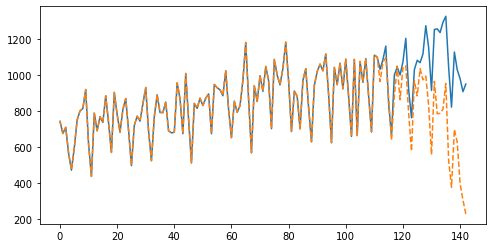

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-08-11":"2021-12"].tolist(), linestyle="dashed")
plt.show()

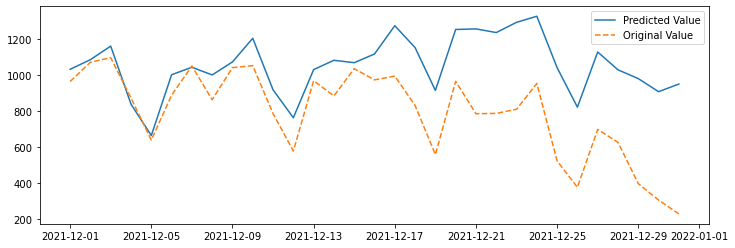

MAE: 261.93174277390204
MAPE: 49.84949846523035
RMSE: 331.30731956199844


In [77]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

672.2559081701553